# Required Libraries

In [ ]:
from pathlib import Path
import os.path

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random


In [ ]:
from tensorflow import keras
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras import Model
from keras.layers.experimental import preprocessing
from keras.layers import Dense, Flatten, Dropout, BatchNormalization


In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns


In [ ]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

In [44]:
# Function to establish constant seeds across various libraries for consistent results
def configure_deterministic_seeds(set_seed=42):
    random.seed(set_seed)

    tf.random.set_seed(set_seed)

    np.random.seed(set_seed)

    session_configuration = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    tf.compat.v1.set_random_seed(set_seed)

    active_session = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_configuration)
    tf.compat.v1.keras.backend.set_session(active_session)

configure_deterministic_seeds()

### Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-04-30 22:56:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-30 22:56:48 (64.4 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



# Data Collection and Transforming Data

In [22]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
from zipfile import ZipFile
filename = "/content/sample_data/archive-3.zip"

with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
# Walk through each directory
dataset = "/content/archive-3"
walk_through_dir(dataset)

There are 12 directories and 0 images in '/content/archive-3'.
There are 0 directories and 500 images in '/content/archive-3/bees'.
There are 0 directories and 485 images in '/content/archive-3/grasshopper'.
There are 0 directories and 323 images in '/content/archive-3/earthworms'.
There are 0 directories and 499 images in '/content/archive-3/ants'.
There are 0 directories and 416 images in '/content/archive-3/beetle'.
There are 0 directories and 466 images in '/content/archive-3/earwig'.
There are 0 directories and 497 images in '/content/archive-3/moth'.
There are 0 directories and 391 images in '/content/archive-3/slug'.
There are 0 directories and 485 images in '/content/archive-3/weevil'.
There are 0 directories and 498 images in '/content/archive-3/wasp'.
There are 0 directories and 434 images in '/content/archive-3/catterpillar'.
There are 0 directories and 500 images in '/content/archive-3/snail'.


# Placing data into a Dataframe
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">

In [27]:
def path_to_Dataframe(dataset):
    image_dir = Path(dataset)

    # Get Directory paths and name tags
    directory_path = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    tags = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], directory_path))

    directory_path = pd.Series(directory_path, name='directory_path').astype(str)
    tags = pd.Series(tags, name='tags')

    # Concatenate path_to_Dataframe and tags
    img_dataframe = pd.concat([directory_path, tags], axis=1)
    return img_dataframe

img_dataframe = path_to_Dataframe(dataset)

In [ ]:
# Detecting Corrupted images in the dataset.
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("/content/__MACOSX").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

## Distribution of images in each class

<ipython-input-31-7ae4ddfb9b4e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_count.index, y=tag_count.values, alpha=0.8, palette='rocket')


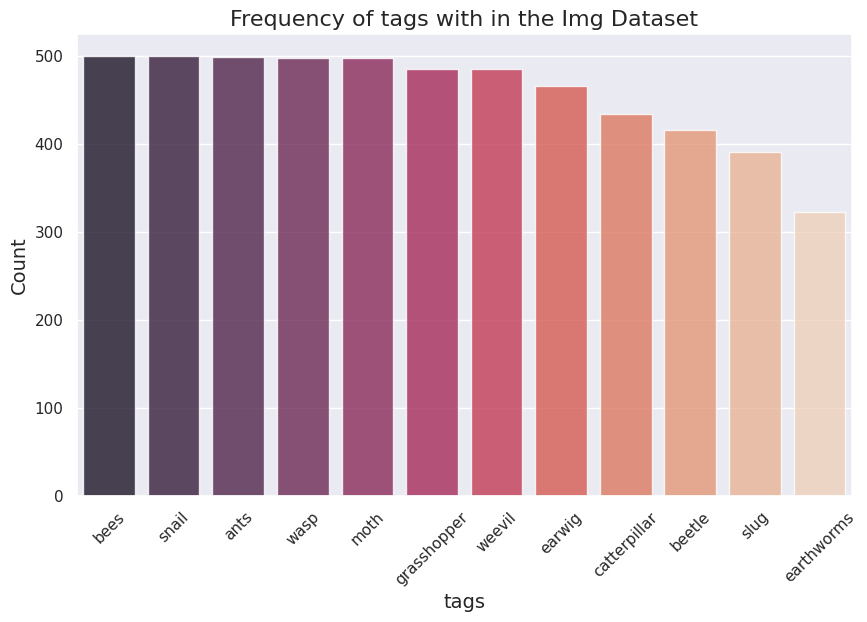

In [31]:
tag_count = img_dataframe['tags'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_count.index, y=tag_count.values, alpha=0.8, palette='rocket')
plt.title('Frequency of tags with in the Img Dataset', fontsize=16)
plt.xlabel('tags', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()


# Visualizing images from the dataset

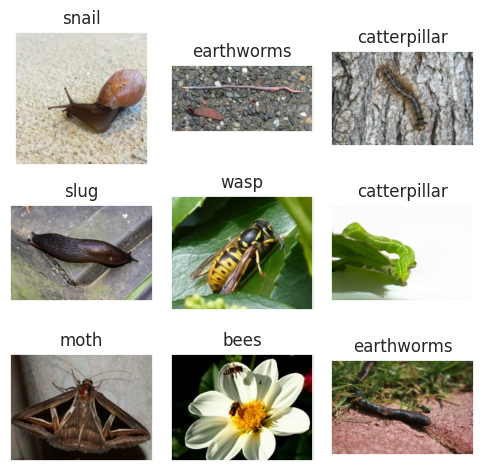

In [34]:
# visualize a selection of 9 dataset images alongside their name tags
random_index = np.random.randint(0, len(img_dataframe), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(5, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(img_dataframe.directory_path[random_index[i]]))
    ax.set_title(img_dataframe.tags[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em"></p>

In [35]:
# Dividing the TEST and TRAIN data
train_df, test_df = train_test_split(img_dataframe, test_size=0.2, shuffle=True, random_state=42)

In [36]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [40]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='directory_path',
    y_col='tags',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='directory_path',
    y_col='tags',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='directory_path',
    y_col='tags',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3516 validated image filenames belonging to 12 classes.
Found 879 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 12 classes.


In [41]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [16]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='max'
)

resnet_model.trainable = False

# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss",  # watch the validation loss metric
                               patience=5,         # stop training if no improvement for 5 epochs
                               restore_best_weights=True)  # restore best weights based on validation loss

# Add additional layers for the custom head of the model
inputs = resnet_model.input
x = augment(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = resnet_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(12, activation='softmax')(x)

In [18]:
# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)

Epoch 1/10
110/110 [==============================] - 986s 9s/step - loss: 4.9436 - accuracy: 0.1163 - val_loss: 2.3088 - val_accuracy: 0.2366
Epoch 2/10
110/110 [==============================] - 956s 9s/step - loss: 2.4432 - accuracy: 0.1527 - val_loss: 2.1875 - val_accuracy: 0.3333
Epoch 3/10
110/110 [==============================] - 937s 9s/step - loss: 2.3135 - accuracy: 0.2130 - val_loss: 2.0091 - val_accuracy: 0.3925
Epoch 4/10
110/110 [==============================] - 927s 8s/step - loss: 2.2104 - accuracy: 0.2679 - val_loss: 1.8468 - val_accuracy: 0.4255
Epoch 5/10
110/110 [==============================] - 953s 9s/step - loss: 2.0627 - accuracy: 0.3385 - val_loss: 1.7318 - val_accuracy: 0.4619
Epoch 6/10
110/110 [==============================] - 1018s 9s/step - loss: 1.9626 - accuracy: 0.3712 - val_loss: 1.6015 - val_accuracy: 0.5085
Epoch 7/10
110/110 [==============================] - 950s 9s/step - loss: 1.8696 - accuracy: 0.4039 - val_loss: 1.4987 - val_accuracy: 0.580

In [42]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

35/35 [==============================] - 247s 7s/step - loss: 1.2878 - accuracy: 0.6379
Test Loss: 1.287814974784851
Test Accuracy: 0.6378526091575623


# Training the model
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">
</p>




In [46]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [47]:
# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [48]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

# Training the CNN model

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

# Add new classification layers
x = Flatten()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(12, activation='softmax')(x) # 12 classes

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "pests_cats_classification"),
        checkpoint_callback,
    ]
)

# Model Evaluation
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.39907
Test Accuracy: 88.44%


# Visualizing accuracy and loss plots

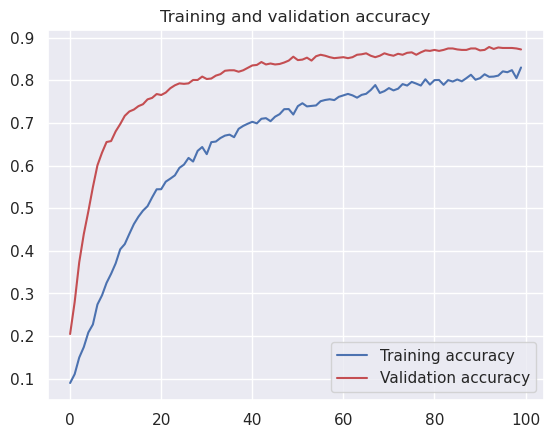

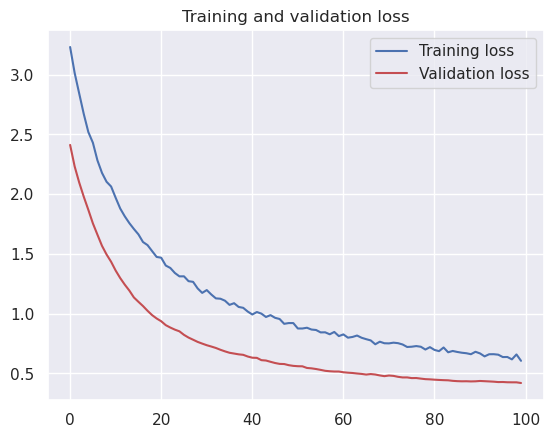

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_img)
pred = np.argmax(pred,axis=1)

tags = (train_img.class_indices)
tags = dict((v,k) for k,v in tags.items())
pred = [tags[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

35/35 [==============================] - 15s 216ms/step
The first 5 predictions: ['bees', 'grasshopper', 'moth', 'earthworms', 'wasp']


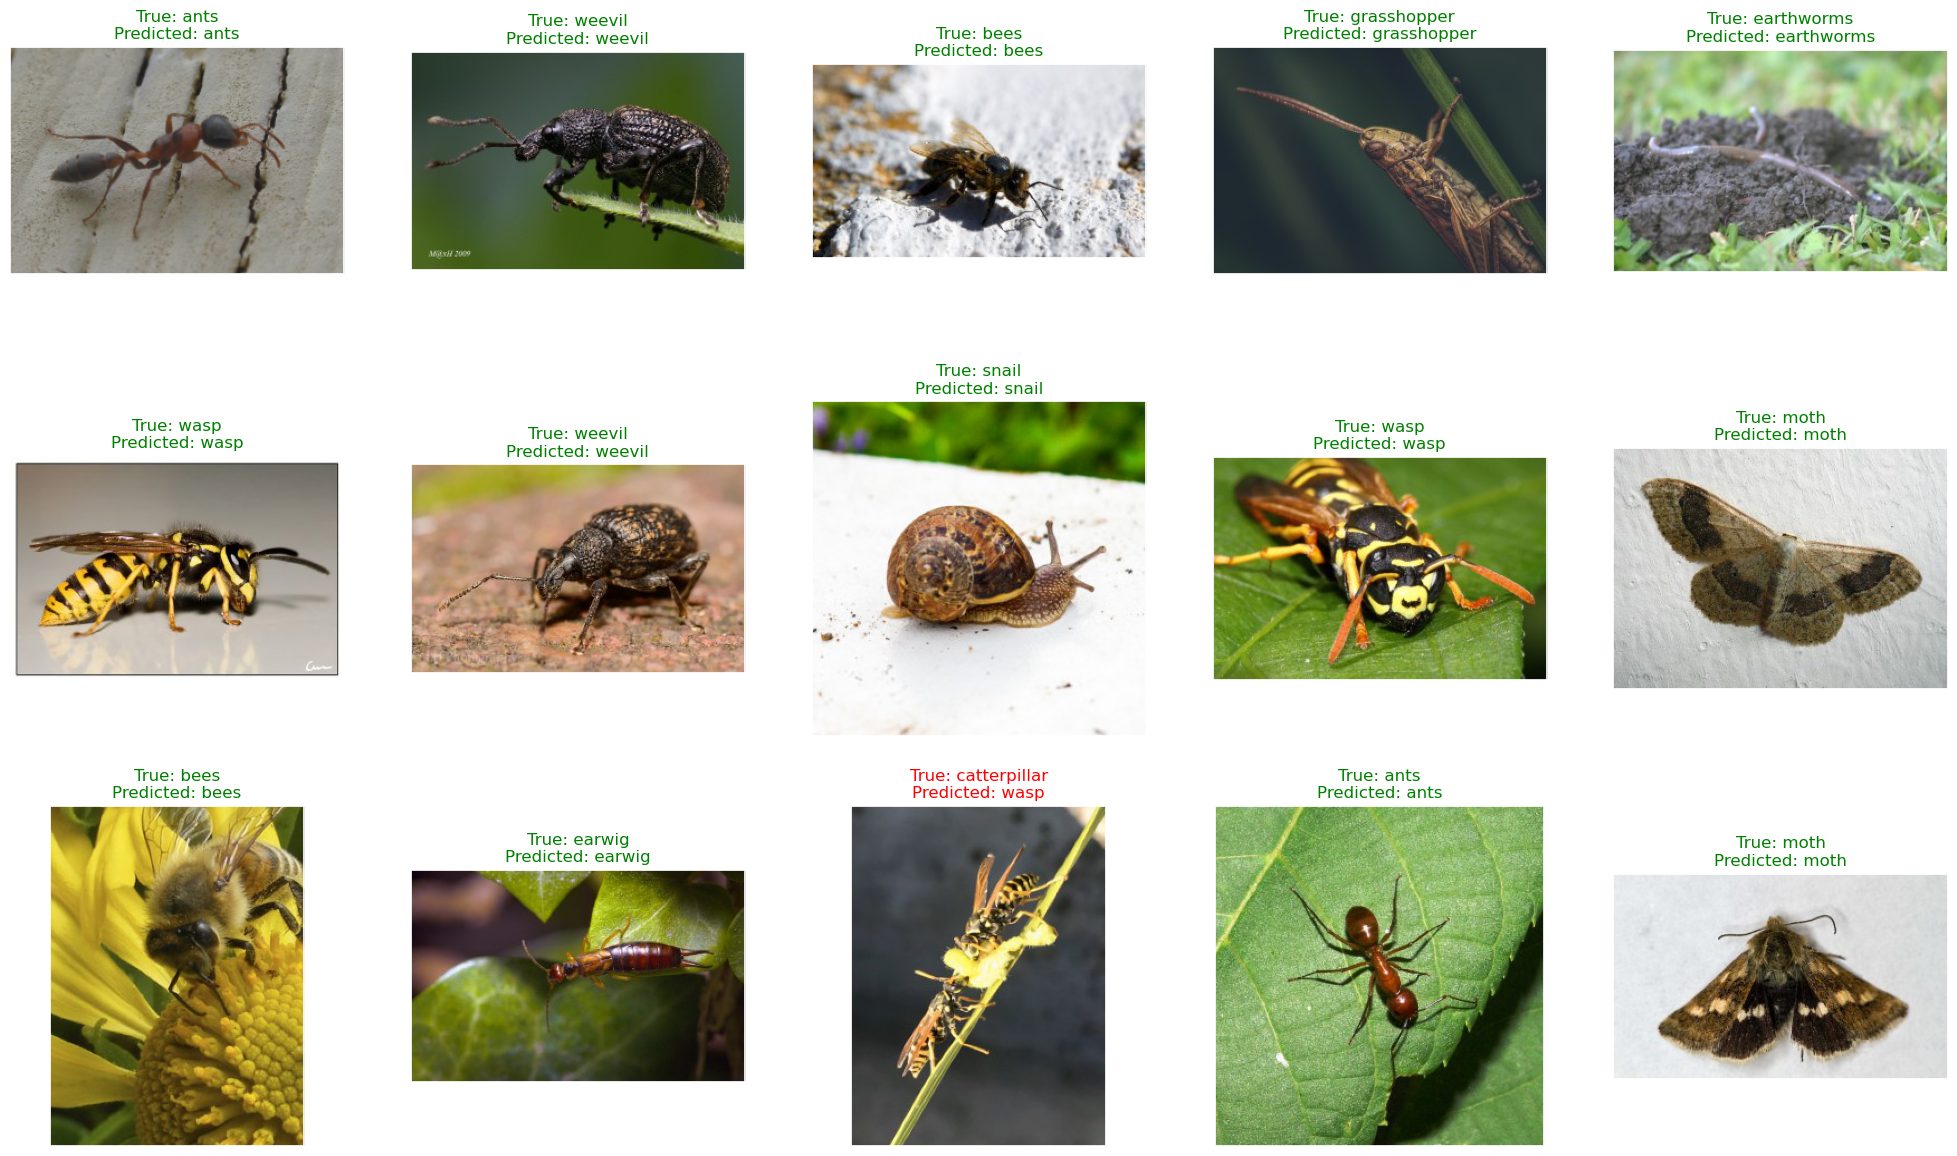

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.directory_path.iloc[random_index[i]]))
    if test_df.tags.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.tags.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Evaluation using Classification Report

In [ ]:
y_test = list(test_df.tags)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        ants       0.91      1.00      0.95        94
        bees       0.87      0.91      0.89        92
      beetle       0.91      0.71      0.80        94
catterpillar       0.64      0.81      0.72        85
  earthworms       0.90      0.79      0.84        67
      earwig       0.92      0.69      0.79        89
 grasshopper       0.94      0.91      0.93       105
        moth       0.87      0.91      0.89        99
        slug       0.90      0.92      0.91        76
       snail       1.00      1.00      1.00       102
        wasp       0.89      0.90      0.90       104
      weevil       0.91      1.00      0.95        92

    accuracy                           0.88      1099
   macro avg       0.89      0.88      0.88      1099
weighted avg       0.89      0.88      0.88      1099



# Confusion Matrix

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        tags = classes
    else:
        tags = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


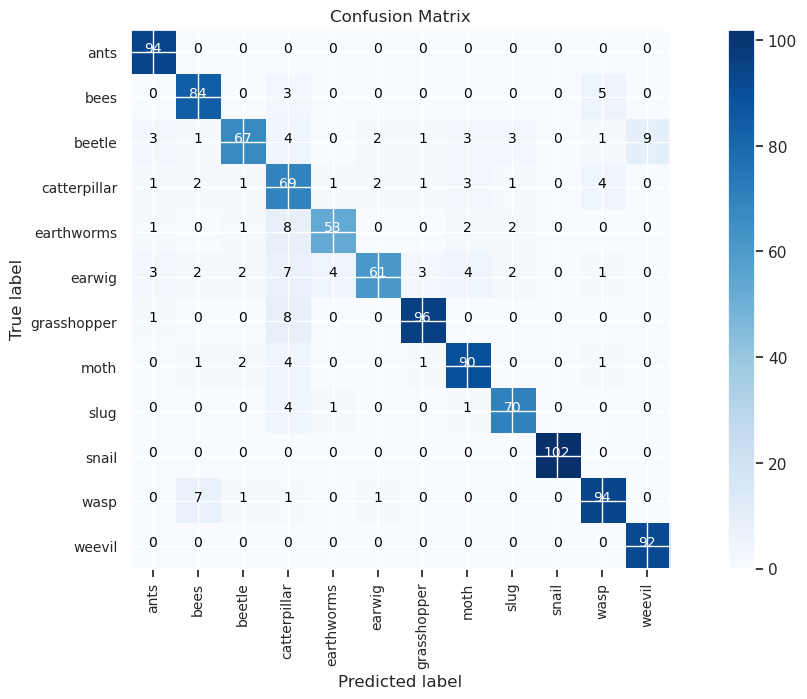

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>

# Model Interpretabilty using Grad-Cam Visualization


In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    return cam_path


preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

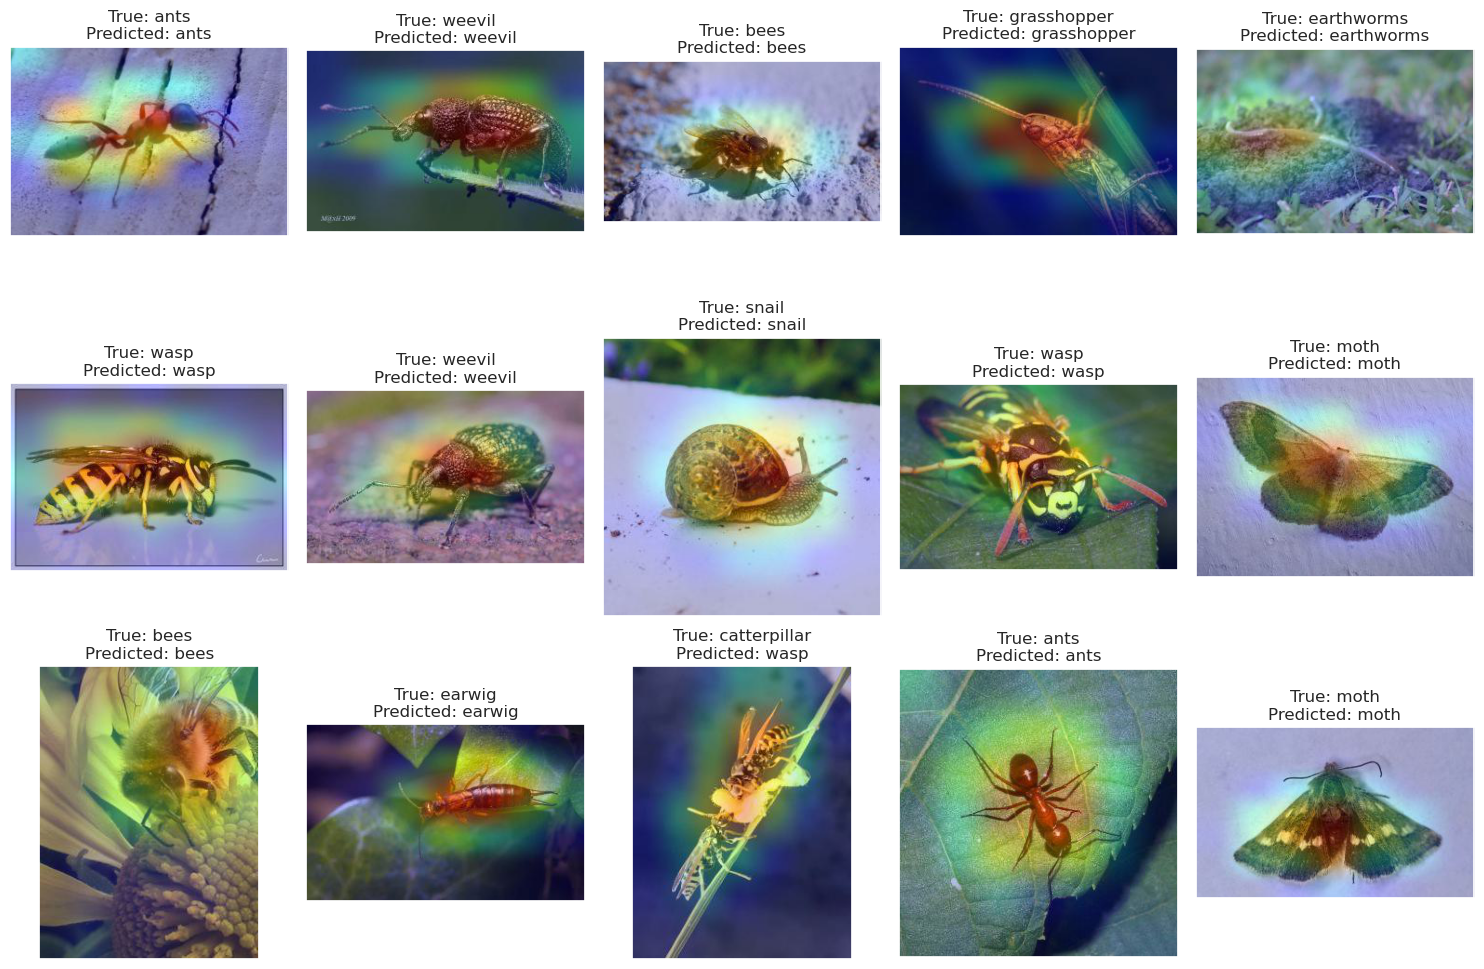

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()